*The codes were developed on Windows 10, and were not tested on other machines. Anaconda 5.2.0 is chosen as a Python interpreter.*

This notebook introduces the concept and methodology of implementing Bootstrap Simulation.

# Bootstrap Simulation

> **Bootstrap Simulation** is a non-parametric statistical technique to resample from known samples to estimate uncertainty in summary statistics. When there are small, limited number of samples, it gives a more accurate forecast model than directly obtaining a forecast model from the limited sample pool. It is non-parametric because it does not require any prior knowledge of the distribution (shape, mean, standard devation, etc..).

One goal of inferential statistics is to determine the value of a parameter of an entire population. It is typically too expensive or even impossible to measure this directly. So we use statistical sampling. We sample a population, measure a statistic of this sample, and then use this statistic to say something about the corresponding parameter of the population.

Bootstrapping is a type of resampling method to save time and money taking measurements. From a sample pool of size N, it picks a random value N times **with replacement**, and create M number of new Bootstrapped-sample pools. The term **with replacement** here means that you put back the sample you drew to the original sample pool after adding it to a new Bootstrapped-sample pool. Think of it this way: you randomly choose a file from a folder in your PC, and you *copy* and paste the randomly-chosen file into a new folder. You do not *cut* and paste the file, but you *copy* and paste the file into a new folder. You will have M number of folders, each containing N number of files.

Bootstrapping resamples the original sample pool to generate multiple smaller population of the true population. Each Bootstrap simulation is done by selecting a random value from the sample pool. For example, lets assume that you have the following sample pool of integers:
   
<p><center>Sample Integers = [12, 433, 533, 14, 65, 42, 64]</center></p>

From the sample pool of size N=7, you choose a random value N=7 times, and create a new sample pool of size N=7. In Bootstrap, each newly created sample pool is called a **realization**. You generate many of these realizations, and use them to calculate uncertainties in summary stats.

<p><center>Realization 1 = [12, 533, 533, 65, 12, 14, 42]</center></p>
<p><center>Realization 2 = [65, 14, 533, 65, 433, 64, 14]</center></p>
<p><center>Realization 3 = [433, 64, 533, 14, 14, 64, 12]</center></p>
<p><center>Realization 4 = [14, 65, 65, 433, 533, 12, 12]</center></p>

<div class="alert alert-info">
    <h4>Warning!</h4>
    <p>If your original sample size is N, each of your Bootstrap realization must have a size of N. Arbitrarily changing the size of your new Bootstrap sample pool will result in wrong confidence intervals for summary stats. Recall that the formula for calculating the standard error of the mean is SE = StDev / sqrt(N). On the other hand, you can have as many realizations as you want.</p>
</div>

Bootstrapping is used for three reasons:

1. Bootstrap can obtain confidence interval in any statistics.
2. Bootstrap does not assume anything about a distribution.
3. Bootstrap helps when there are to few number of samples.

** Imports **

In [683]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib notebook

## 1.A. Confidence Intervals in Summary Stats: US Male Height - Gaussian Distribution

Bootstrap simulation can be run to obtain confidence intervals in various population parameters: mean, stdev, variance, min, or max. In this example, we will work with the height distribution of the US Male population, which tends to be Gaussian. However, the fact that the distribution Gaussian is totally unrelated to Bootstrap simulation, because it does not assume anything about the distribution.

Bootstrapping can give us confidence intervals in any summary statistics like the following:

<div class="alert alert-info">
    <p>By 95% chance, the following statistics will fall within the range of:</p>
    <br><b>Mean : </b>75.2 ~ 86.2, with 80.0 being the average
    <br><b>Standard Deviation : </b>2.3 ~ 3.4 with 2.9 being the average
    <br><b>Min : </b>54.3 ~ 57.2, with 55.2 being the average
    <br><b>Max : </b>77.8 ~ 82.4, with 79.8 being the average
    <br><b>Skew : </b>-0.053 ~ 0.323, with 0.023 being the average</p>    
</div>

###  1.A.0. Bootstrap Scripts

** Bootstrap Simulator **

In [684]:
def bootstrap_simulation(sample_data, size_realization, num_realizations):
    boot = []
    for i in range(num_realizations):
        real = np.random.choice(sample_data.values.flatten(), size=N)
        boot.append(real)
        
    columns = ['Real ' + str(i + 1) for i in range(num_realizations)]
    
    return pd.DataFrame(boot, index=columns).T

** Summary Statistics Calculator **

In [685]:
def calc_sum_stats(boot_df):
    sum_stats = boot_df.describe().T[['mean', 'std', 'min', 'max']]
    sum_stats['variance'] = boot_df.var()
    sum_stats['skew'] = boot_df.skew()
    sum_stats['kurtosis'] = boot_df.kurtosis()
    sum_stats['IQR'] = boot_df.quantile(0.75) - boot_df.quantile(0.25)
    return sum_stats.T

** Visualization Script **

In [759]:
def visualize_distribution(dataframe, ax_):
    dataframe = dataframe.apply(lambda x: x.sort_values().values)
    
    for col, label in zip(dataframe, dataframe.columns):
        fit = stats.norm.pdf(dataframe[col], np.mean(dataframe[col]), np.std(dataframe[col]))
        ax_.plot(dataframe[col], fit)
    ax_.set_ylabel('Probability')

** Generate Confidence Intervals **

In [813]:
def calc_bounds(conf_level):
    
    assert (conf_level < 1), "Confidence level must be smaller than 1"
    
    margin = (1 - conf_level) / 2
    upper = conf_level + margin
    lower = margin
    return margin, upper, lower

def calc_confidence_interval(df_sum_stats, conf_level): 
    
    margin, upper, lower = calc_bounds(conf_level)
    
    conf_int_df = df_sum_stats.T.describe(percentiles=[lower, 0.5, upper]).iloc[4:7, :].T
    conf_int_df.columns = ['P' + str(round(lower * 100, 1)), 'P50', 'P' + str(round(upper * 100, 1))]
    return conf_int_df 

def print_confidence_interval(conf_df, conf_level):
    print('By {}% chance, the following statistics will fall within the range of:\n'.format(round(conf_level * 100, 1)))
    
    margin, upper, lower = calc_bounds(conf_level)
    
    upper_str = 'P' + str(round(upper * 100, 1))
    lower_str = 'P' + str(round(lower * 100, 1))
    
    for stat in conf_df.T.columns:
        lower_bound = round(conf_df[lower_str].T[stat], 1)
        upper_bound = round(conf_df[upper_str].T[stat], 1)

        mean = round(conf_df['P50'].T[stat], 1)
        print("{0:<10}: {1:>10}  ~ {2:>10} , AVG = {3:>5}".format(stat, lower_bound, upper_bound, mean))

### 1.A.1 Sample Data Description

100 samples of US male height data is provided in **sample_data/US_Male_Height.csv**. Summary statistics of the sample data can be calculated. Your goal is to calculate the confidence intervals for the summary stats.

In [650]:
# height data
height_data = pd.read_csv('sample_data/US_Male_Height.csv')
height_data.index = ['Male ' + str(i + 1) for i in range(height_data.shape[0])]
height_data.round(1).T

,Male 1,Male 2,Male 3,Male 4,Male 5,Male 6,Male 7,Male 8,Male 9,Male 10,...,Male 91,Male 92,Male 93,Male 94,Male 95,Male 96,Male 97,Male 98,Male 99,Male 100
Height (in),70.8,72.8,72.5,67.3,72.7,73.6,65.0,67.1,70.8,70.6,...,71.7,66.4,72.9,74.5,73.5,70.5,73.1,63.6,68.7,73.0


In [651]:
height_summary_stats = calc_sum_stats(height_data)
height_summary_stats

,Height (in)
mean,69.881971
std,3.169548
min,63.143732
max,77.762886
variance,10.046035
skew,-0.059779
kurtosis,-0.700743
IQR,5.154145


** Visualization **

<IPython.core.display.Javascript object>


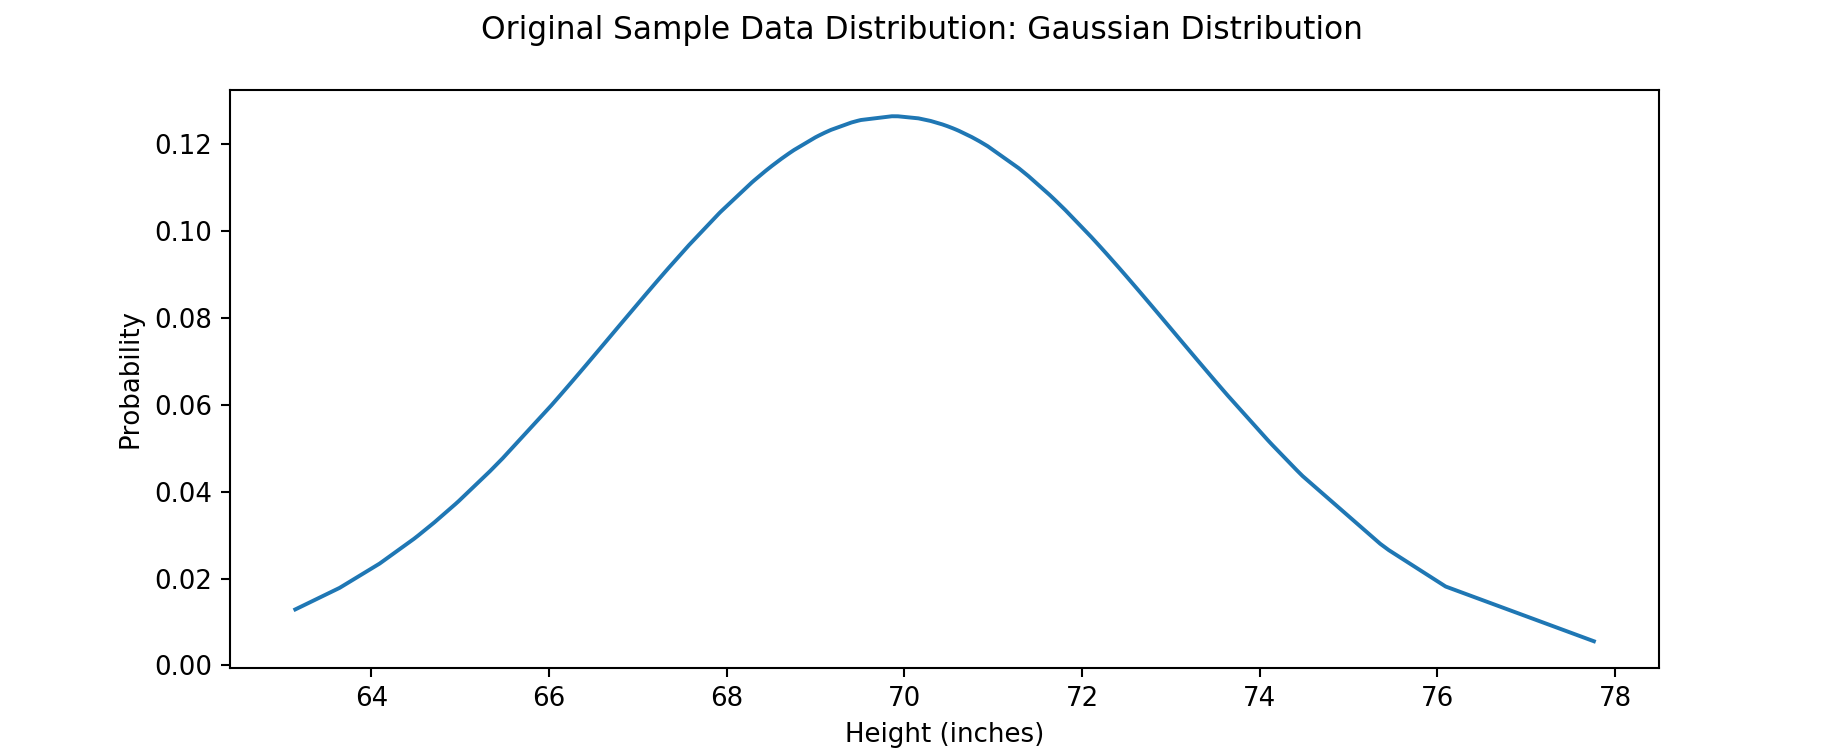

In [664]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel('Height (inches)');
fig.suptitle('Original Sample Data Distribution: Gaussian Distribution')

visualize_distribution(height_data, ax);

Based on the distribution plot of the original sample data, we can observe that the distribution indeed looks Gaussian. However, the fact that it looks like Gaussian does not matter at all when Bootstrapping, because Bootstrapping does not assume anything about the distribution. 

### 1.A.2 Resampling From the Sample Data

Each Bootstrap resampling (realization) can be done in one-line with [numpy.random.choice()](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html). Each realization is an array of size N, where N is the length of the original sample data. There are M number of realizations, where M is an arbitrary number of your choice. 

** Results **

In [653]:
N = height_data.shape[0]     # size of each realiztion
M = 100                      # number of realizations - arbitrary
bootstrap_data = bootstrap_simulation(height_data, N, M)
bootstrap_data.round(1).head(10)

,Real 1,Real 2,Real 3,Real 4,Real 5,Real 6,Real 7,Real 8,Real 9,Real 10,...,Real 91,Real 92,Real 93,Real 94,Real 95,Real 96,Real 97,Real 98,Real 99,Real 100
0,70.2,67.9,75.4,68.8,72.9,69.1,73.6,76.1,69.9,72.5,...,68.3,64.5,72.1,70.4,68.4,68.7,65.5,73.6,71.8,72.9
1,70.5,70.3,66.2,69.9,66.6,68.7,70.3,69.2,66.4,69.2,...,70.4,70.3,69.1,72.4,69.9,63.6,73.5,63.1,73.1,67.6
2,66.1,73.6,73.0,71.4,69.1,73.0,63.1,72.2,71.6,64.5,...,71.8,64.7,75.5,64.1,65.3,64.7,72.2,72.7,69.2,72.2
3,66.8,67.1,73.1,73.3,64.7,73.5,70.8,68.3,65.3,76.1,...,67.2,71.3,64.1,72.9,71.8,72.2,66.8,71.8,69.5,66.8
4,65.5,73.5,69.1,73.5,66.0,68.5,63.1,69.0,64.5,66.2,...,77.8,73.0,69.0,64.5,72.1,72.8,69.2,70.6,63.1,72.7
5,77.8,66.3,66.2,66.4,68.4,68.6,69.5,65.3,74.5,72.5,...,74.1,65.0,71.6,73.1,72.9,73.0,69.0,64.9,70.8,70.5
6,66.4,69.4,66.0,70.2,64.7,70.6,65.0,66.6,74.5,72.8,...,66.0,66.0,71.4,71.6,66.4,65.5,72.1,69.1,64.5,69.5
7,64.5,74.1,65.0,65.0,73.1,67.6,73.1,72.1,69.2,73.3,...,67.6,67.2,67.9,70.6,69.1,75.4,69.5,65.3,72.5,73.5
8,69.1,63.6,66.6,72.8,72.1,66.3,74.1,72.4,71.6,72.9,...,74.5,69.2,73.1,77.8,73.5,67.3,66.4,66.4,66.4,73.6
9,67.6,68.3,67.9,69.9,67.2,74.5,72.2,76.1,77.8,67.1,...,71.4,72.2,73.1,73.6,68.3,72.5,70.5,70.2,72.8,67.2


In [654]:
boot_sum_stats = calc_sum_stats(bootstrap_data)
boot_sum_stats.round(1)

,Real 1,Real 2,Real 3,Real 4,Real 5,Real 6,Real 7,Real 8,Real 9,Real 10,...,Real 91,Real 92,Real 93,Real 94,Real 95,Real 96,Real 97,Real 98,Real 99,Real 100
mean,69.1,69.8,69.8,69.5,69.7,70.3,70.0,70.0,69.8,70.0,...,70.0,70.1,69.7,70.3,69.8,69.3,69.9,70.0,69.9,70.1
std,3.2,3.5,3.1,3.2,3.2,3.2,3.5,3.2,3.5,3.3,...,3.4,3.0,3.2,3.1,3.1,3.2,2.9,3.2,3.2,3.1
min,63.1,63.1,63.1,63.6,63.1,63.1,63.1,63.6,63.6,64.1,...,63.1,63.1,63.1,64.1,63.1,63.1,64.5,63.1,63.1,63.6
max,77.8,76.1,77.8,76.1,77.8,77.8,77.8,77.8,77.8,76.1,...,77.8,75.5,76.1,77.8,77.8,75.5,76.1,77.8,77.8,77.8
variance,10.5,12.0,9.4,10.0,10.4,10.4,12.0,10.3,12.4,10.6,...,11.4,8.8,10.3,9.5,9.6,10.0,8.3,10.3,10.3,9.9
skew,0.3,-0.2,-0.0,-0.1,0.0,0.0,0.2,0.2,0.2,-0.2,...,0.1,-0.4,0.0,0.1,0.1,0.1,0.2,-0.1,-0.2,-0.3
kurtosis,-0.6,-1.0,-0.8,-1.1,-0.7,-0.7,-0.6,-0.6,-0.6,-1.1,...,-0.7,-0.8,-1.0,-0.6,-0.5,-0.8,-0.9,-0.6,-0.8,-0.7
IQR,5.3,5.7,5.2,5.4,5.0,4.7,5.6,5.0,5.9,5.6,...,5.1,4.6,6.1,4.6,5.0,4.6,4.9,5.2,4.7,4.9


** Visualize **

<IPython.core.display.Javascript object>


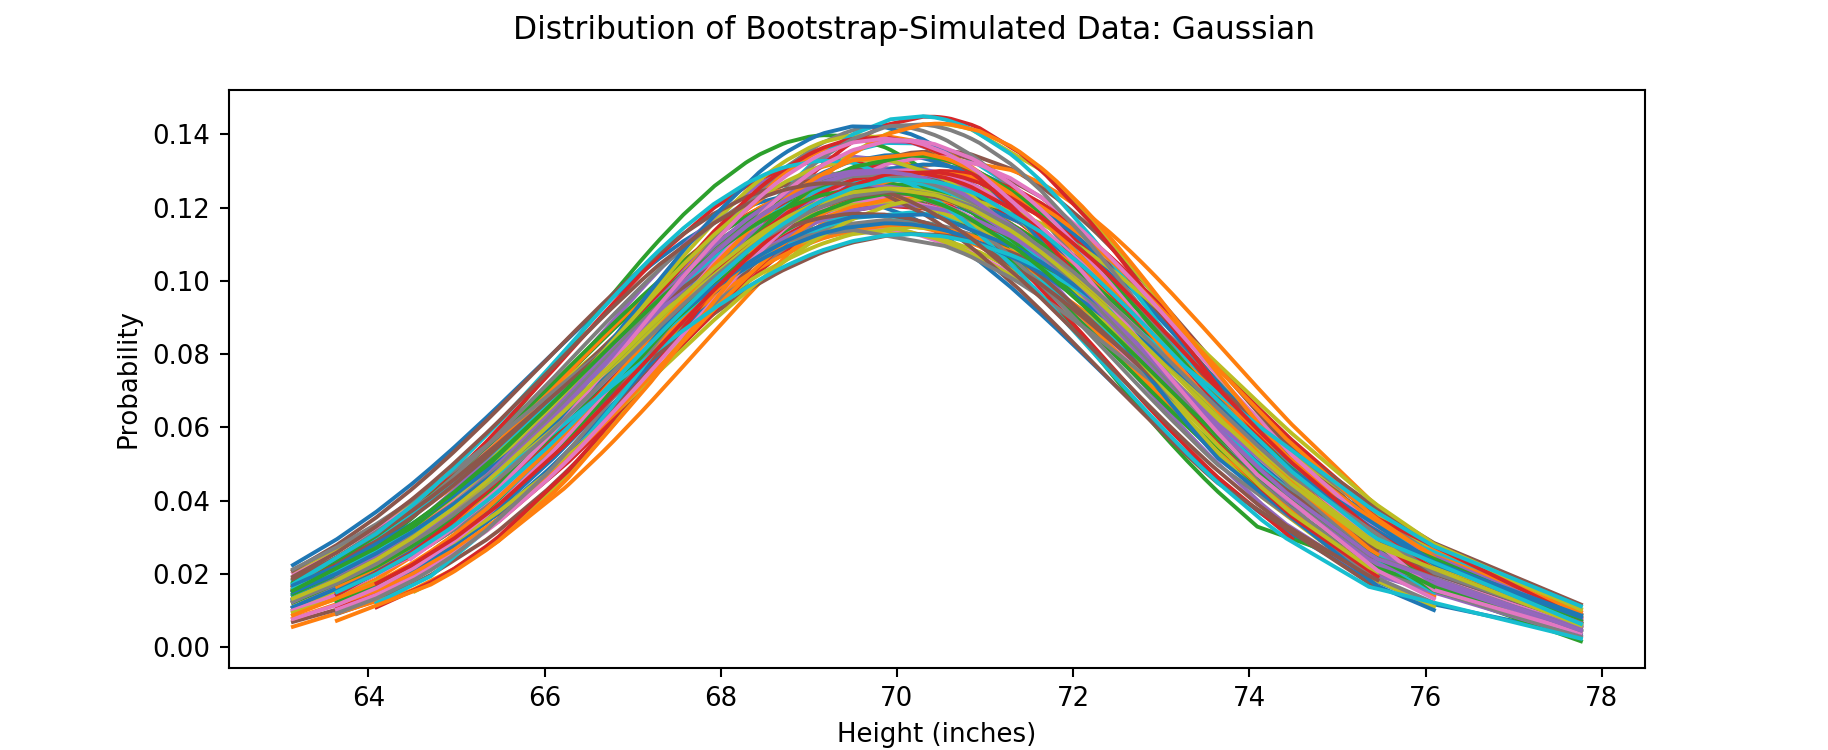

In [693]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel('Height (inches)');
fig.suptitle('Distribution of Bootstrap-Simulated Data: Gaussian')
visualize_distribution(bootstrap_data, ax);

<div class="alert alert-info">
    <p>Each line in the plot represents one Bootstrap realization. There are 100 realizations, each having 100 random samples.</p> 
</div>

### 1.A.3 Uncertainty Models in Summary Statistics with Blox Plots

<IPython.core.display.Javascript object>


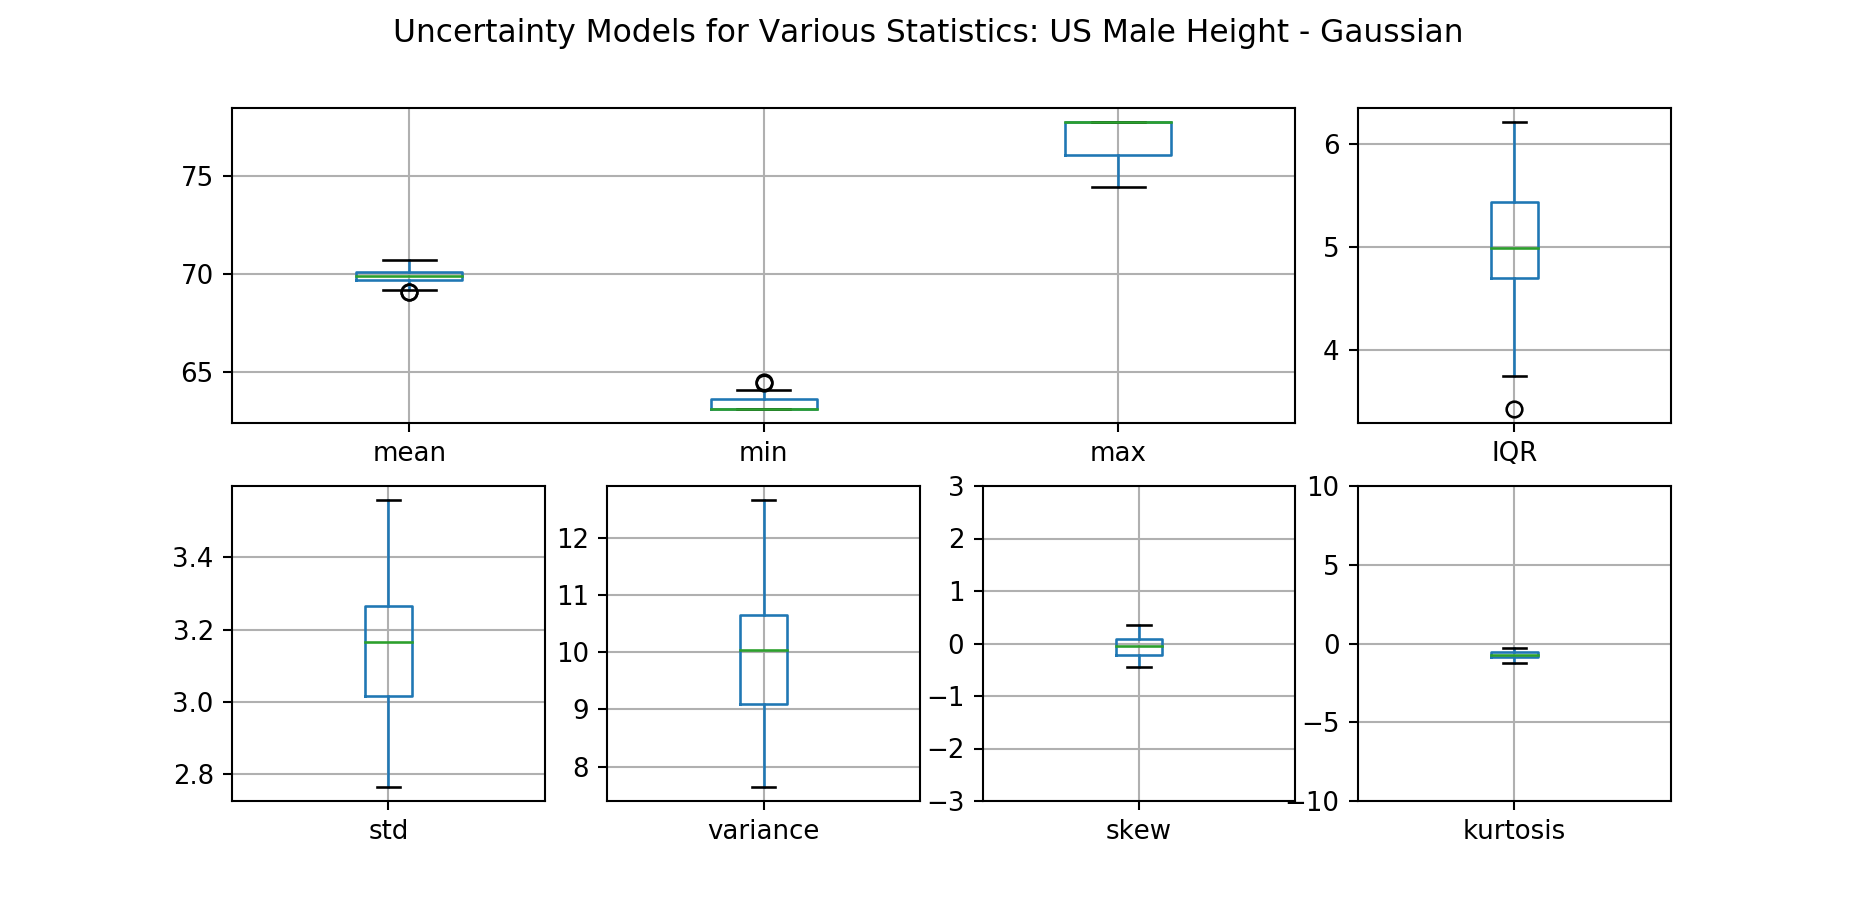

In [707]:
f = plt.figure()
plt.suptitle('Uncertainty Models for Various Statistics: US Male Height - Gaussian')

gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(gs[0, 0:3])
ax2 = plt.subplot(gs[0, 3])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1])
ax5 = plt.subplot(gs[1, 2])
ax6 = plt.subplot(gs[1, 3])

boot_sum_stats.T[['mean', 'min', 'max']].boxplot(ax=ax1)
boot_sum_stats.T[['IQR']].boxplot(ax=ax2)
boot_sum_stats.T[['std']].boxplot(ax=ax3)
boot_sum_stats.T[['variance']].boxplot(ax=ax4)
boot_sum_stats.T[['skew']].boxplot(ax=ax5)
boot_sum_stats.T[['kurtosis']].boxplot(ax=ax6)

ax5.set_ylim([-3, 3])
ax6.set_ylim([-10, 10]);

### 1.A.4 Confidence Interval in Summary Statistics

Confidence intervals of summary statistics usually have a confidence level of 90%, 95%, or 99%. In this case, we will choose **95% confidence level**. 

In [814]:
confidence_level = 0.95

conf_int = calc_confidence_interval(boot_sum_stats, confidence_level)
conf_int.round(1)

,P2.5,P50,P97.5
mean,69.2,69.9,70.5
std,2.8,3.2,3.5
min,63.1,63.1,64.1
max,75.5,77.8,77.8
variance,7.9,10.0,12.4
skew,-0.4,-0.1,0.2
kurtosis,-1.1,-0.7,-0.3
IQR,4.0,5.0,6.0


In [815]:
print_confidence_interval(conf_int, confidence_level)

By 95.0% chance, the following statistics will fall within the range of:

mean      :       69.2  ~       70.5 , AVG =  69.9
std       :        2.8  ~        3.5 , AVG =   3.2
min       :       63.1  ~       64.1 , AVG =  63.1
max       :       75.5  ~       77.8 , AVG =  77.8
variance  :        7.9  ~       12.4 , AVG =  10.0
skew      :       -0.4  ~        0.2 , AVG =  -0.1
kurtosis  :       -1.1  ~       -0.3 , AVG =  -0.7
IQR       :        4.0  ~        6.0 , AVG =   5.0


## 1.B. Confidence Intervals in Summary Stats: Rock Permeability - Lognormal Distribution



It was previously stated that Bootstrapping does not assume anything about the distribution. Is that really true? The previous example of the US Male Height distribution was a Gaussian distribution. But what if the distribution of our interest is not Gaussian? 

In this example, rock pearmeability, which has a **lognormal distribution**, will be used to show that Bootstrap does not depend on the type of the distribution. 

### 1.B.0. Bootstrap Scripts

The sample scripts used for US Male Height example will be used for Bootstrap simulation. Same scripts can be used for both Gaussian and lognormal distribution because Bootstrapping does not assume anything about the distribution.

### 1.B.1. Sample Data Description

105 samples of permeability data is provided in **sample_data/PoroPermSampleData.xlsx**. Permeability data is taken at many times at different depth of a wellbore.

Summary statistics of the sample data can be calculated. Your goal is to calculate the confidence intervals for the summary stats. 

<IPython.core.display.Javascript object>


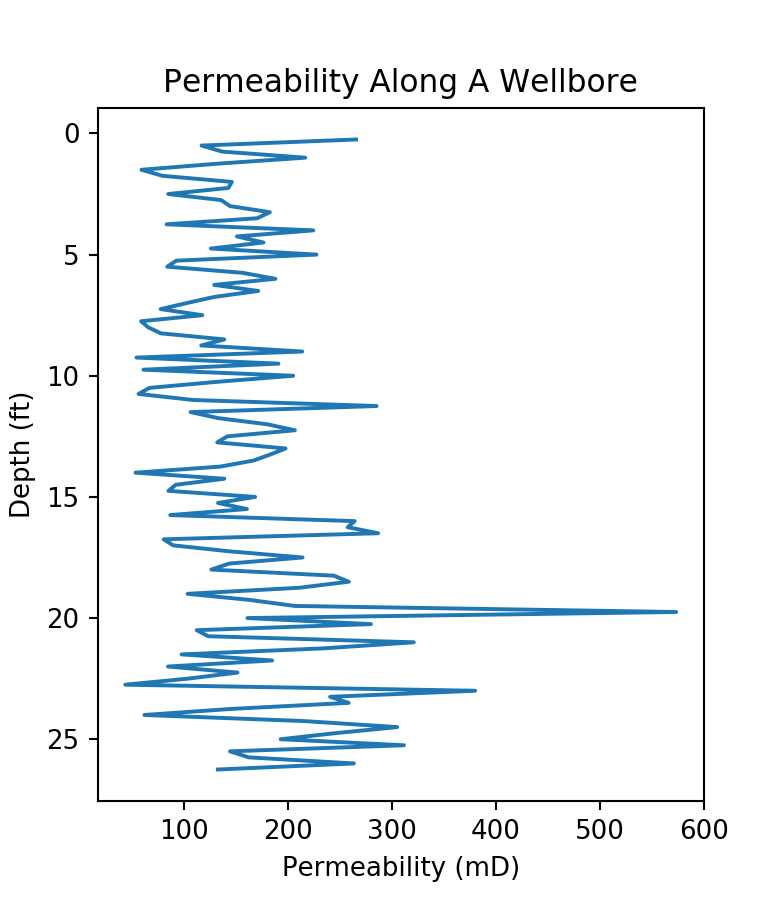

In [687]:
# permeability data
perm_depth_data = pd.read_excel('sample_data/PoroPermSampleData.xlsx', sheet_name='Sheet1')[['Depth', 'Permeability (mD)']]
perm_data = perm_depth_data['Permeability (mD)'].to_frame()

# visualize
fig = plt.figure()
ax = plt.axes()

ax.plot(perm_depth_data['Permeability (mD)'], perm_depth_data['Depth']);
ax.invert_yaxis()
ax.set_title('Permeability Along A Wellbore')
ax.set_xlabel('Permeability (mD)')
ax.set_ylabel('Depth (ft)');

In [688]:
perm_summary_stats = calc_sum_stats(perm_data)
perm_summary_stats

,Permeability (mD)
mean,161.008972
std,80.900128
min,43.534147
max,573.461883
variance,6544.830649
skew,1.625086
kurtosis,5.498080
IQR,102.580432


** Visualization **

<IPython.core.display.Javascript object>


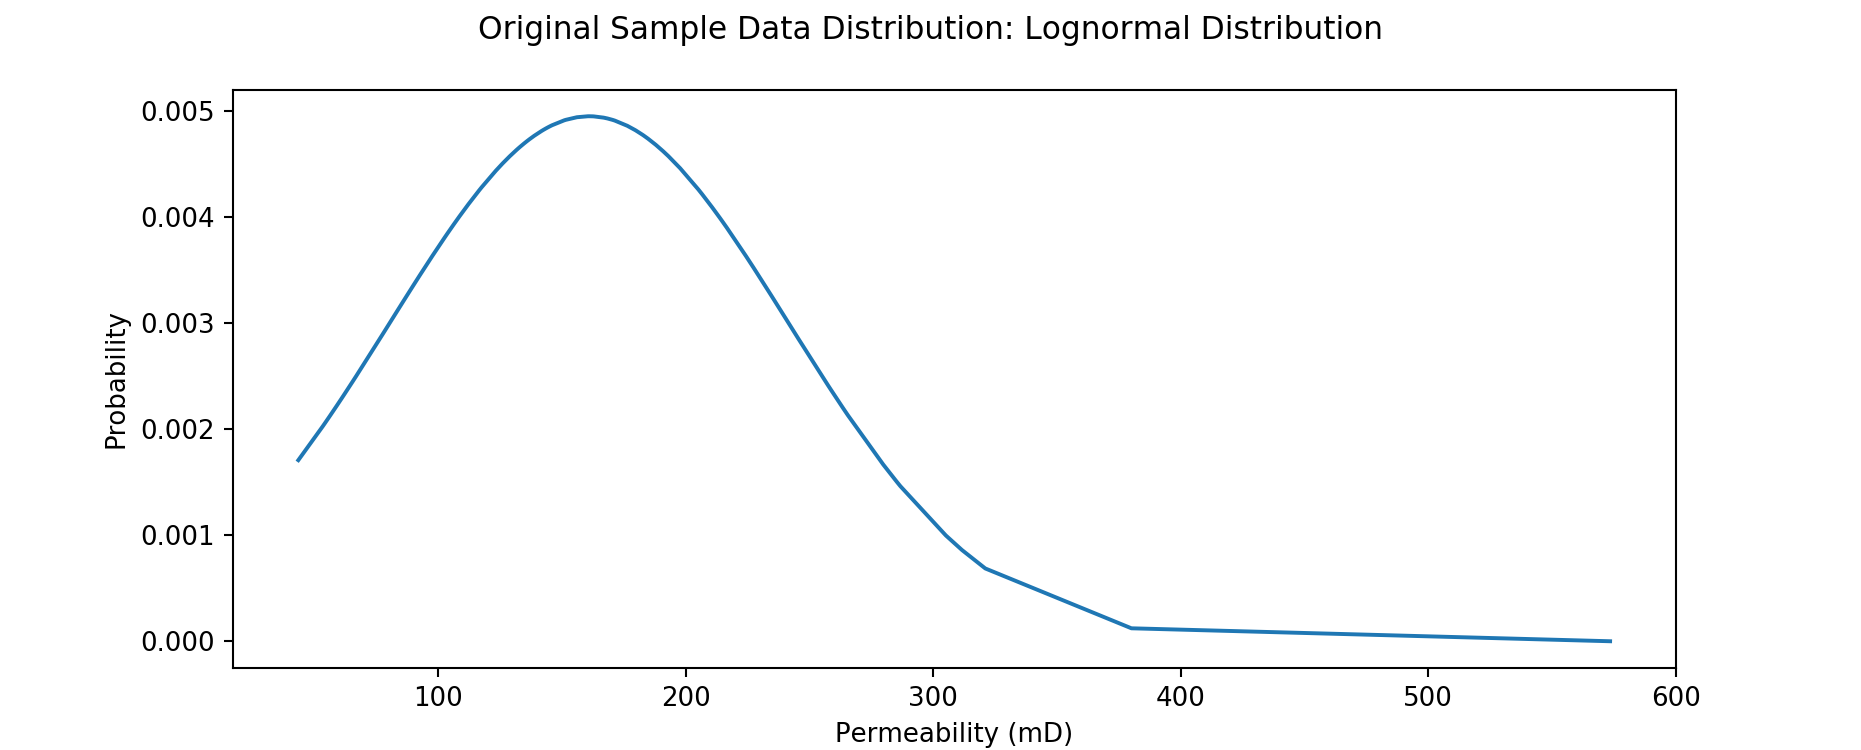

In [699]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel('Permeability (mD)')
fig.suptitle('Original Sample Data Distribution: Lognormal Distribution')
visualize_distribution(perm_data, ax);

Based on the distribution of the original sample data, we can observe that the distribution looks lognormal. The uncertainty in summary statistics can be calculated using Bootstrap the same way it was done for the US Male Height (Gaussian) distribution, because Bootstrap does not depend on the shape of the distribution.

<div class="alert alert-info">
    <h4>Warning!</h4>
    <p>Outlier removal on rock permeability cannot be done directly, as this is a lognormal distribution. Recall that the typical outlier removal method assumes the distribution to be Gaussian. If you want to detect outliers for non-Gaussian distributions, you have to first transform the distribution into Gaussian.</p>
</div>

### 1.B.2 Resampling From the Sample Data

Each Bootstrap resampling (realization) can be done in one-line with [numpy.random.choice()](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html). Each realization is an array of size N, where N is the length of the original sample data. There are M number of realizations, where M is an arbitrary number of your choice. 

** Results **

In [690]:
N = perm_data.shape[0]       # size of each realiztion
M = 100                      # number of realizations - arbitrary
boot_perm_data = bootstrap_simulation(perm_data, N, M)
boot_perm_data.round(1).head(10)

,Real 1,Real 2,Real 3,Real 4,Real 5,Real 6,Real 7,Real 8,Real 9,Real 10,...,Real 91,Real 92,Real 93,Real 94,Real 95,Real 96,Real 97,Real 98,Real 99,Real 100
0,144.4,162.3,380.1,311.6,183.1,190.9,214.9,305.1,244.1,205.1,...,61.9,151.0,206.6,132.0,156.1,56.3,97.7,133.2,79.4,112.3
1,79.4,77.5,146.0,53.4,166.9,263.5,160.5,234.5,279.8,234.5,...,151.0,116.9,244.1,171.4,106.4,132.1,234.5,170.5,102.7,132.7
2,258.4,146.0,227.4,151.5,311.6,79.4,79.4,85.0,135.8,321.1,...,123.3,143.7,227.4,132.0,77.8,144.4,58.8,112.3,161.0,144.7
3,80.4,116.9,85.0,184.8,84.7,65.6,144.4,61.9,43.5,54.3,...,224.4,146.0,134.7,116.9,79.4,263.5,214.1,161.0,179.7,132.7
4,214.9,205.1,179.7,103.5,103.5,179.7,573.5,156.1,214.1,176.4,...,227.4,86.8,227.4,134.7,112.3,380.1,193.1,108.6,83.3,190.9
5,126.3,265.5,80.4,182.6,61.9,265.5,162.9,61.0,264.2,190.9,...,129.1,216.7,206.6,146.0,227.4,206.6,85.0,79.4,244.1,128.9
6,210.8,135.8,206.7,162.9,214.9,162.9,171.4,138.8,125.9,156.1,...,179.7,92.7,162.9,311.6,214.9,161.0,116.6,133.2,56.3,65.6
7,145.6,123.3,573.5,264.2,305.1,305.1,171.4,265.5,213.7,84.9,...,132.7,83.3,197.8,171.4,92.1,176.4,286.8,77.5,108.6,89.6
8,108.6,184.8,210.8,305.1,136.9,134.7,240.6,132.1,263.5,134.7,...,183.1,166.9,160.5,79.4,183.1,213.7,116.6,227.4,86.8,206.6
9,166.9,108.6,285.3,141.8,151.0,83.9,193.1,133.2,80.4,129.1,...,97.7,216.7,79.4,224.4,117.6,132.0,102.7,58.8,112.3,162.9


In [691]:
boot_perm_sum_stats = calc_sum_stats(boot_perm_data)
boot_perm_sum_stats.round(1)

,Real 1,Real 2,Real 3,Real 4,Real 5,Real 6,Real 7,Real 8,Real 9,Real 10,...,Real 91,Real 92,Real 93,Real 94,Real 95,Real 96,Real 97,Real 98,Real 99,Real 100
mean,176.5,166.7,176.0,175.4,173.2,156.0,150.3,158.6,170.9,160.6,...,157.6,163.0,153.4,167.2,153.4,163.2,164.8,156.6,167.2,160.8
std,98.0,87.4,98.0,85.4,78.8,85.8,73.8,79.3,86.2,70.0,...,78.1,91.4,80.9,64.4,67.5,78.1,83.9,75.0,88.9,78.9
min,53.4,54.3,53.4,43.5,53.4,53.4,43.5,53.4,43.5,43.5,...,43.5,43.5,43.5,56.3,53.4,53.4,43.5,58.8,53.4,43.5
max,573.5,573.5,573.5,380.1,573.5,573.5,573.5,573.5,573.5,321.1,...,573.5,573.5,573.5,380.1,311.6,380.1,573.5,380.1,573.5,573.5
variance,9598.7,7630.9,9610.8,7290.9,6207.9,7353.7,5442.6,6282.7,7438.5,4897.9,...,6105.3,8346.0,6546.5,4145.2,4558.1,6100.0,7039.0,5622.8,7911.2,6218.8
skew,2.0,2.1,2.1,0.5,1.4,1.6,1.9,1.7,1.3,0.4,...,1.8,1.9,1.8,0.6,0.3,0.6,1.3,0.7,1.3,1.7
kurtosis,5.9,7.3,6.2,-0.6,5.0,4.5,9.1,6.3,3.5,-0.5,...,6.8,6.3,6.2,0.3,-1.0,-0.2,4.2,-0.2,3.0,6.1
IQR,90.4,91.4,88.9,129.1,89.0,105.9,101.0,88.5,87.8,94.3,...,84.4,108.9,108.1,80.8,111.0,122.2,106.8,118.7,124.7,96.5


** Visualize **

<IPython.core.display.Javascript object>


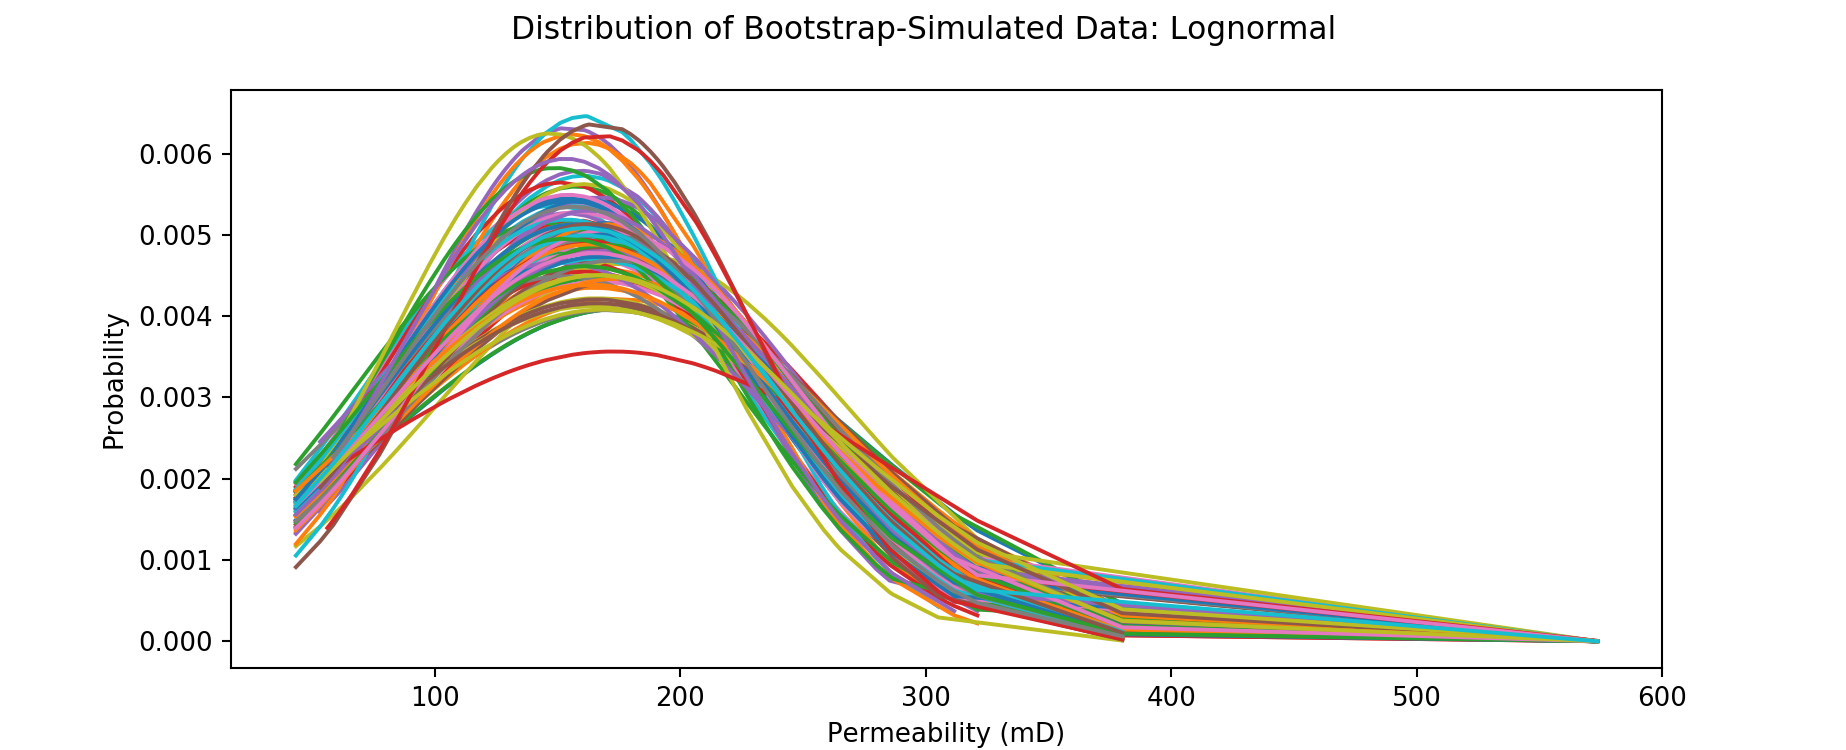

In [700]:
fig, ax = plt.subplots(figsize=(8, 4))
fig.suptitle('Distribution of Bootstrap-Simulated Data: Lognormal')
ax.set_xlabel('Permeability (mD)')
visualize_distribution(boot_perm_data, ax);

### 1.B.3 Uncertainty Models in Summary Statistics with Blox Plots

<IPython.core.display.Javascript object>


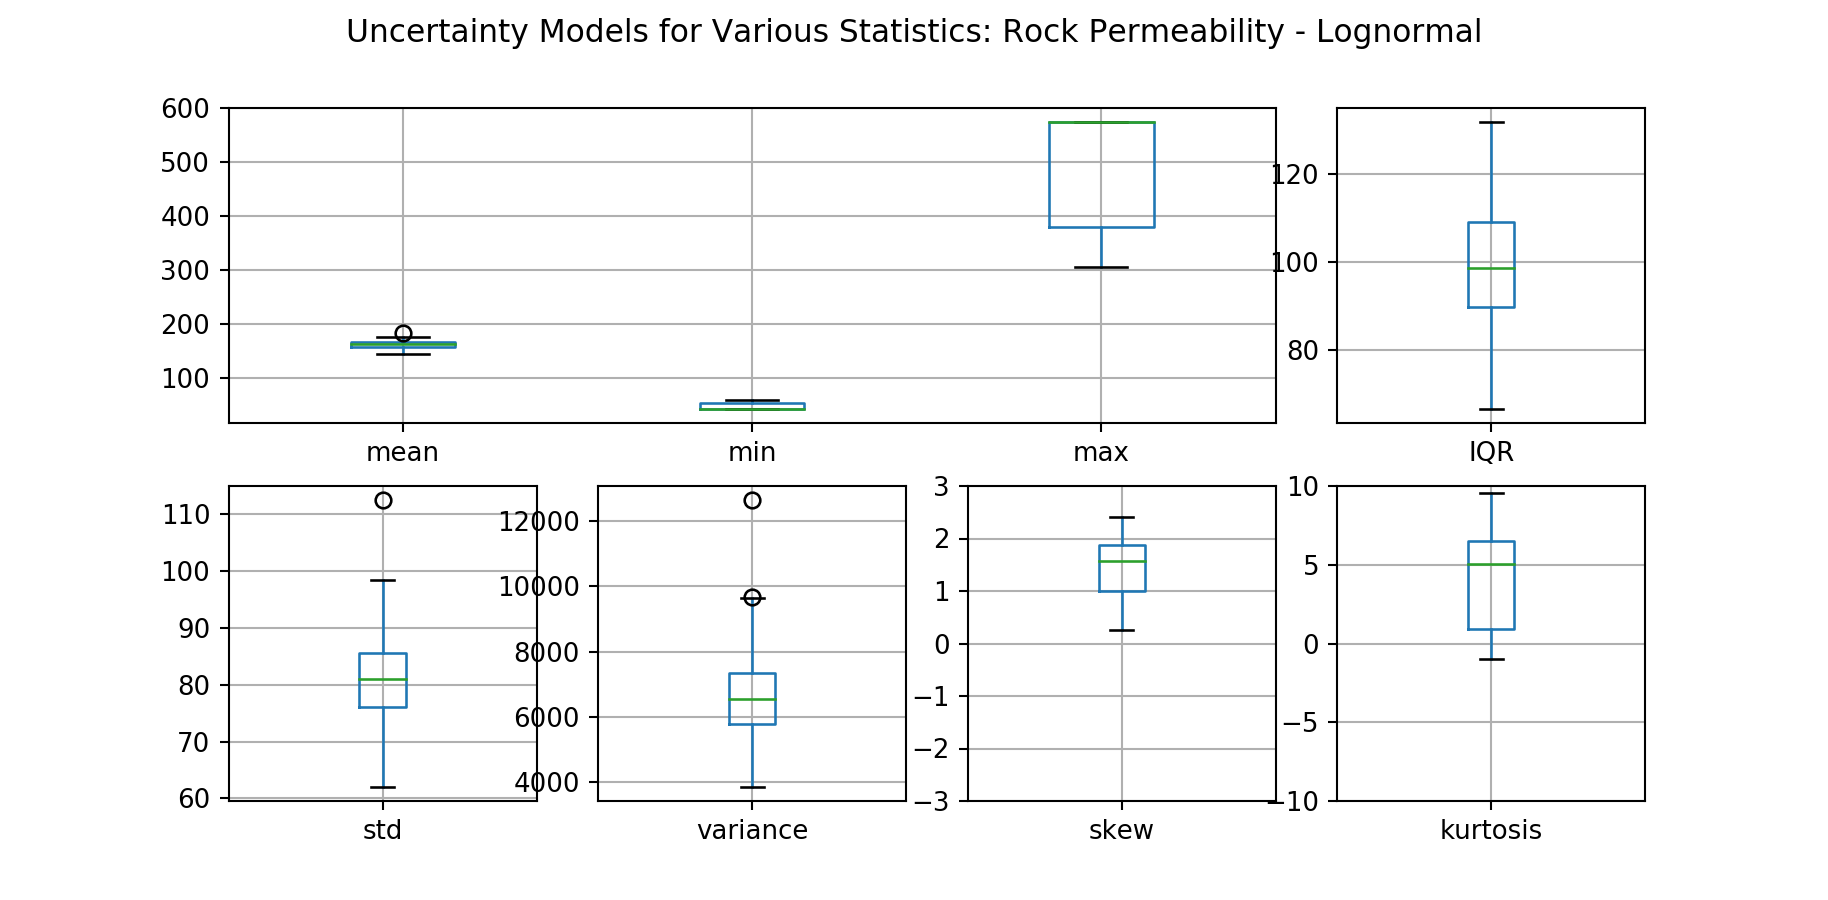

In [708]:
f = plt.figure()
plt.suptitle('Uncertainty Models for Various Statistics: Rock Permeability - Lognormal')

gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(gs[0, 0:3])
ax2 = plt.subplot(gs[0, 3])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1])
ax5 = plt.subplot(gs[1, 2])
ax6 = plt.subplot(gs[1, 3])

boot_perm_sum_stats.T[['mean', 'min', 'max']].boxplot(ax=ax1)
boot_perm_sum_stats.T[['IQR']].boxplot(ax=ax2)
boot_perm_sum_stats.T[['std']].boxplot(ax=ax3)
boot_perm_sum_stats.T[['variance']].boxplot(ax=ax4)
boot_perm_sum_stats.T[['skew']].boxplot(ax=ax5)
boot_perm_sum_stats.T[['kurtosis']].boxplot(ax=ax6)

ax5.set_ylim([-3, 3])
ax6.set_ylim([-10, 10]);

Observe the **positive skewness** in the boxplot summary statistics. This is consistent with the left-justified lognormal distribution of the permeability plot.

### 1.B.4 Confidence Interval in Summary Statistics

Confidence intervals of summary statistics usually have a confidence level of 90%, 95%, or 99%. In this case, we will choose **90% confidence level**.

In [816]:
confidence_level = 0.9

conf_int_perm = calc_confidence_interval(boot_perm_sum_stats, confidence_level)
conf_int_perm.round(1)

,P5.0,P50,P95.0
mean,150.3,162.5,174.4
std,64.4,80.9,97.3
min,43.5,43.5,56.3
max,321.1,573.5,573.5
variance,4144.6,6551.3,9465.5
skew,0.5,1.6,2.2
kurtosis,-0.5,5.1,8.7
IQR,80.8,98.6,125.9


In [817]:
print_confidence_interval(conf_int_perm, confidence_level)

By 90.0% chance, the following statistics will fall within the range of:

mean      :      150.3  ~      174.4 , AVG = 162.5
std       :       64.4  ~       97.3 , AVG =  80.9
min       :       43.5  ~       56.3 , AVG =  43.5
max       :      321.1  ~      573.5 , AVG = 573.5
variance  :     4144.6  ~     9465.5 , AVG = 6551.3
skew      :        0.5  ~        2.2 , AVG =   1.6
kurtosis  :       -0.5  ~        8.7 , AVG =   5.1
IQR       :       80.8  ~      125.9 , AVG =  98.6


## 2. Limited Number of Samples - Improve Forecast Model by Bootstrapping

